# Nuages de mots

In [1]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Téléchargement des ressources NLTK si nécessaire
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Chemins
data_path = "../../data/txt_tp4"
output_dir = "../../data/results/"
os.makedirs(output_dir, exist_ok=True)

# Stopwords français + bruits spécifiques
sw = set(stopwords.words('french'))
stopwords = sw.union({
    # ... liste étendue des stopwords / bruits ...
})

# Mots-cibles prioritaires
mots_cibles = {
    # ... liste des mots-cibles thématiques ...
}


In [2]:
def nettoyer_texte(text):
    """Nettoyage agressif avec conservation des accents."""
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

def filter_words(words):
    """Filtre les mots en conservant les mots-cibles."""
    words = [w for w in words if w.isalpha() and len(w) > 2]
    words = [w for w in words if w not in stopwords or w in mots_cibles]
    return words

def extract_year(filename):
    """Extraction de l'année depuis le nom de fichier."""
    parts = filename.split("_")
    for part in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None


In [3]:
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
print(f"Nombre de fichiers : {len(files)}")

corpus_global = []
corpus_decennies = {}

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors='ignore') as ff:
        text = nettoyer_texte(ff.read())
    words = filter_words(text.split())

    corpus_global.extend(words)
    corpus_decennies.setdefault(dec, [])
    corpus_decennies[dec].append(" ".join(words))

print("Décennies disponibles :", sorted(corpus_decennies.keys()))
print("Nombre de mots corpus global :", len(corpus_global))


Nombre de fichiers : 999
Décennies disponibles : [1950, 1960, 1970]
Nombre de mots corpus global : 2705605


In [4]:
for dec, textes in corpus_decennies.items():
    print(f"\nAnalyse des années {dec}...")
    combined_text = " ".join(textes)

    vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=list(stopwords))
    X = vectorizer.fit_transform([combined_text])
    feature_names = vectorizer.get_feature_names_out()
    counts = X.toarray()[0]

    ngram_counts = {feature_names[i]: counts[i] for i in range(len(feature_names))
                    if any(mot in feature_names[i].lower() for mot in mots_cibles)}

    if not ngram_counts:
        print(f"Aucune occurrence thématique trouvée pour {dec}.")
        continue

    # Top n-grams
    top_ngrams = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:50]
    print(f"Top 15 n-grammes pour {dec} :")
    for ngram, count in top_ngrams[:15]:
        print(f"  - {ngram} ({count})")



Analyse des années 1960...
Aucune occurrence thématique trouvée pour 1960.

Analyse des années 1970...
Aucune occurrence thématique trouvée pour 1970.

Analyse des années 1950...
Aucune occurrence thématique trouvée pour 1950.


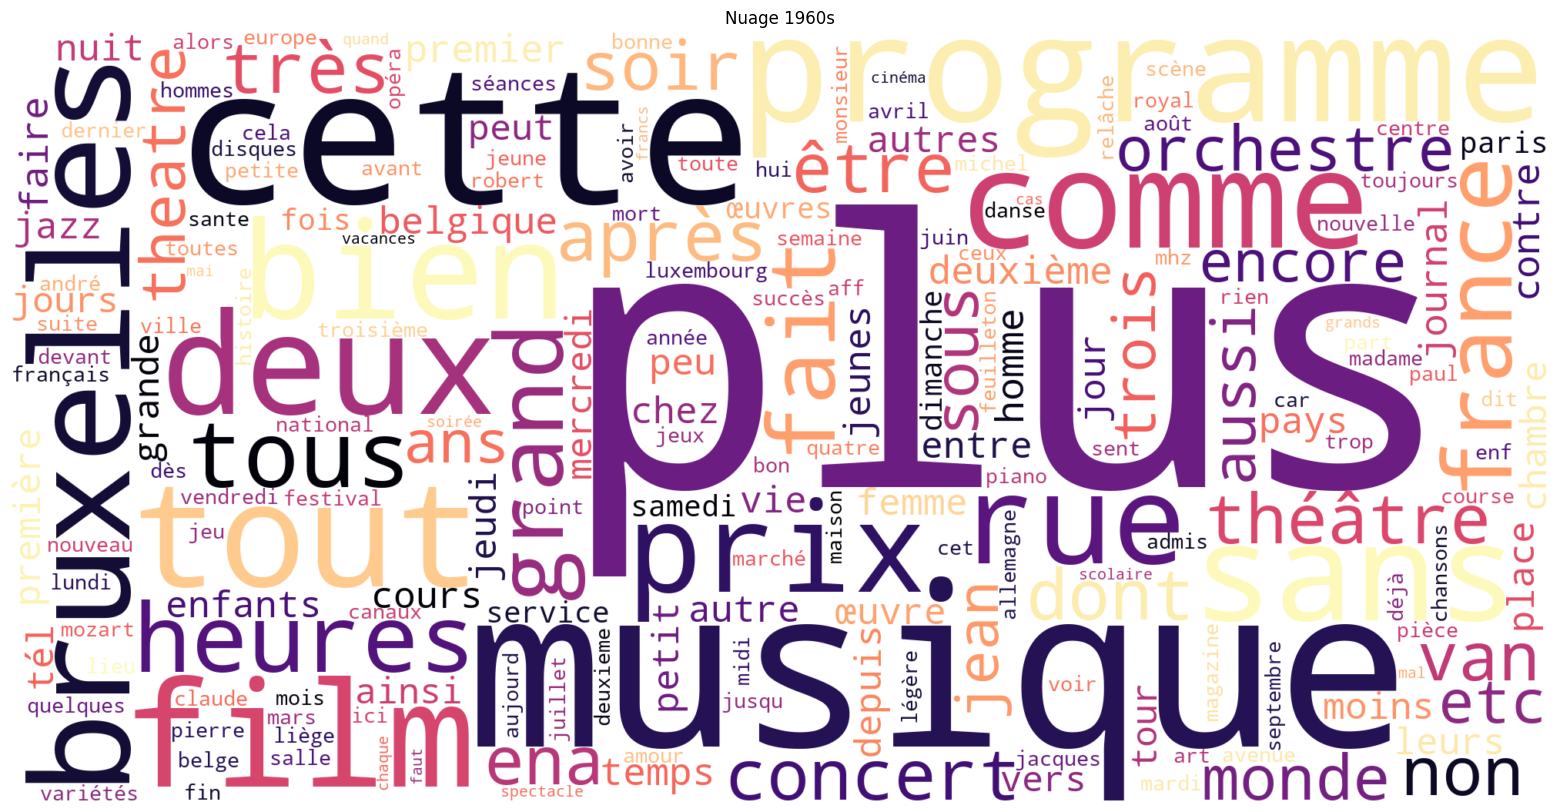

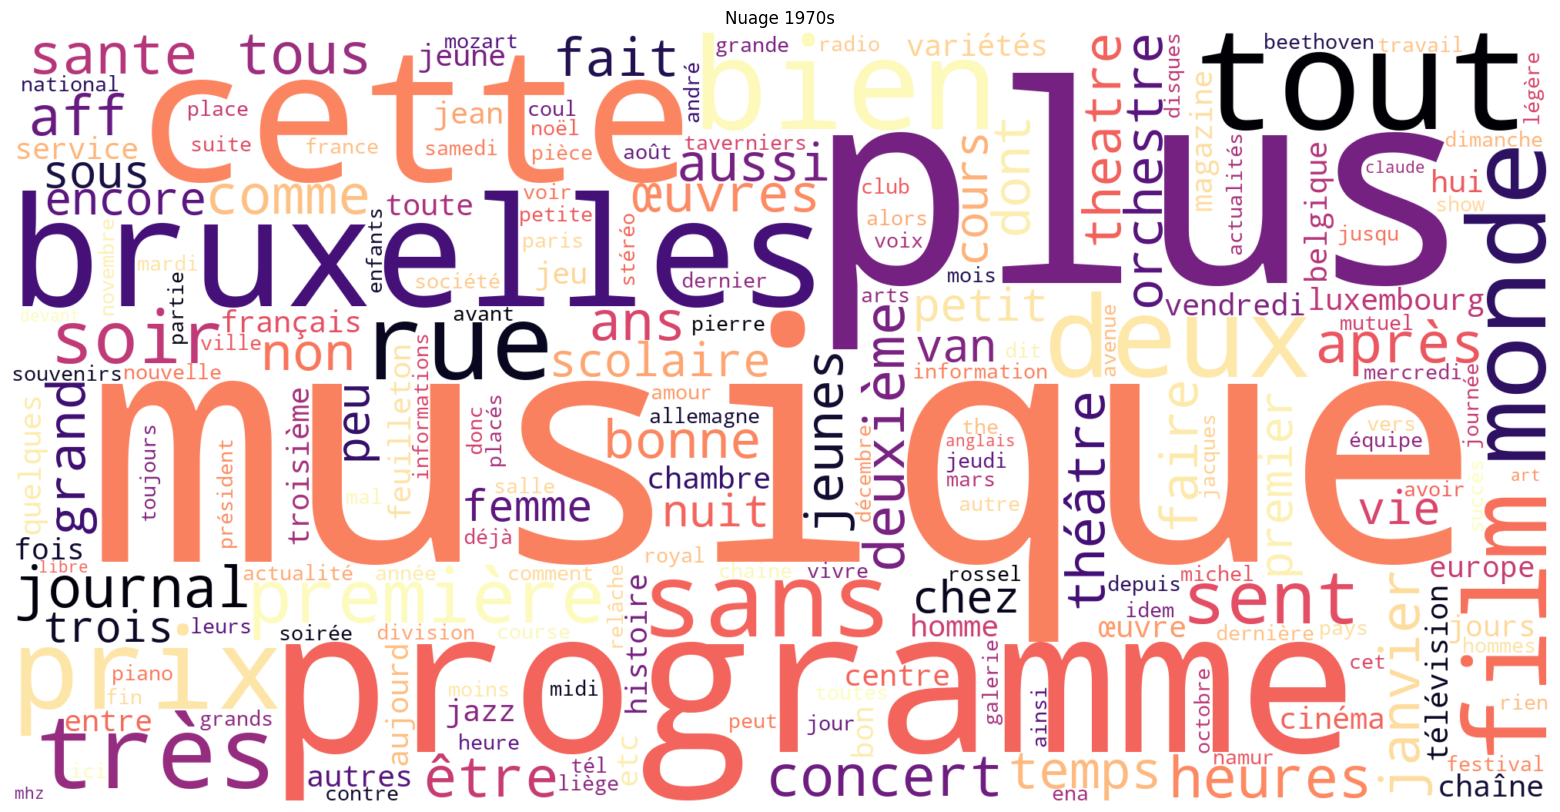

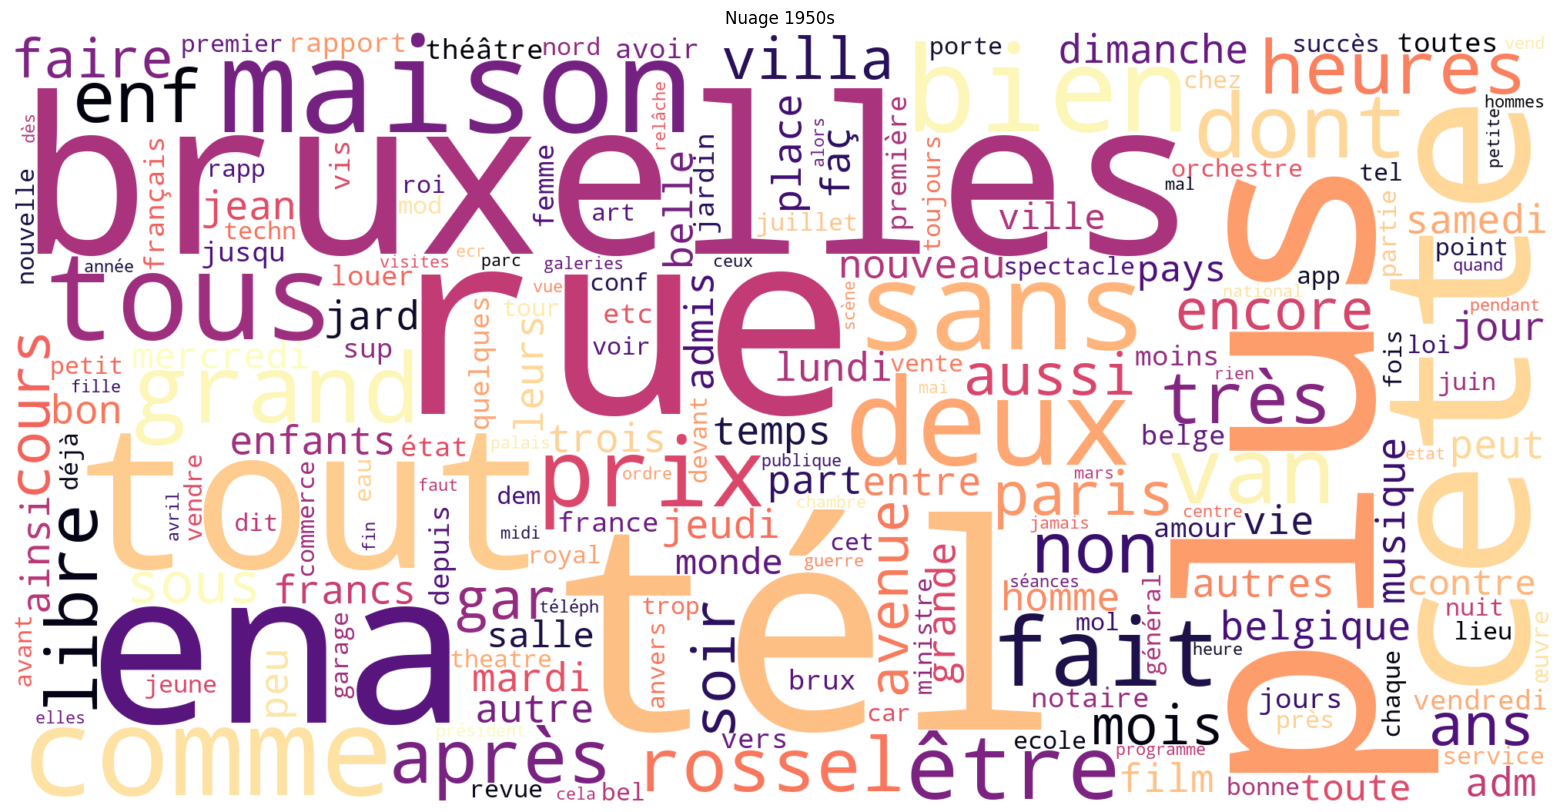

In [5]:
for dec, textes in corpus_decennies.items():
    combined_text = " ".join(textes)
    words_dec = filter_words(combined_text.split())
    freq_dec = Counter(words_dec)

    cloud_dec = WordCloud(
        width=2000, height=1000,
        background_color='white',
        colormap='magma'
    ).generate_from_frequencies(freq_dec)

    plt.figure(figsize=(20,10))
    plt.imshow(cloud_dec, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Nuage {dec}s")
    plt.show()


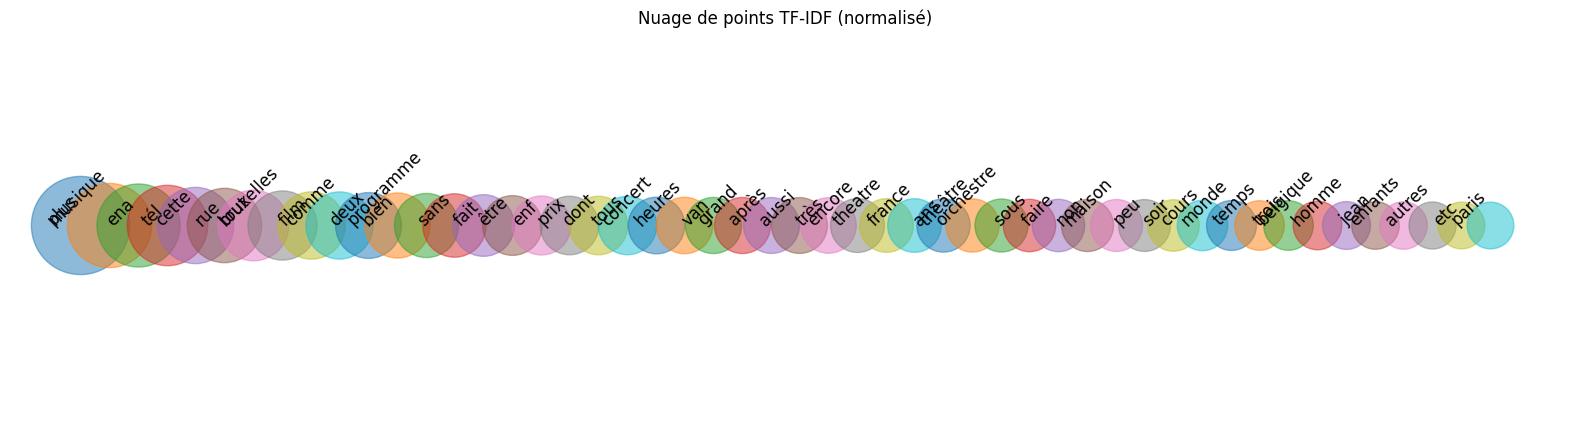

In [6]:
documents = []
for f in files:
    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors='ignore') as ff:
        text = nettoyer_texte(ff.read())
    words = filter_words(text.split())
    documents.append(" ".join(words))

vectorizer = TfidfVectorizer(max_features=50)
X = vectorizer.fit_transform(documents)
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.toarray().mean(axis=0)))
sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)

# Nuage TF-IDF
plt.figure(figsize=(20,5))
max_score = max(score for _, score in sorted_words)
for i, (word, score) in enumerate(sorted_words):
    plt.scatter(i, 0, s=(score/max_score)*5000, alpha=0.5)
    plt.text(i, 0, word, fontsize=12, rotation=45, ha='right')
plt.axis('off')
plt.title("Nuage de points TF-IDF (normalisé)")
plt.show()


In [7]:
with open(f"{output_dir}resultats_ngrams.csv", "w", encoding="utf-8") as f:
    f.write("décennie;ngram;count\n")
    for dec, textes in corpus_decennies.items():
        combined_text = " ".join(textes)
        vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words=list(stopwords))
        X = vectorizer.fit_transform([combined_text])
        feature_names = vectorizer.get_feature_names_out()
        counts = X.toarray()[0]

        for i in range(len(feature_names)):
            if any(mot in feature_names[i].lower() for mot in mots_cibles):
                f.write(f"{dec};{feature_names[i]};{counts[i]}\n")

print(f"Analyse terminée. Résultats exportés dans {output_dir}")


Analyse terminée. Résultats exportés dans ../../data/results/


# Tentatif 2

In [17]:
import os
import re
from collections import Counter
import csv
import numpy as np
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


True

In [9]:
data_path = "../../data/txt_tp4"
output_dir = "../../data/results/"
os.makedirs(output_dir, exist_ok=True)

# Stopwords français
sw = set(stopwords.words('french'))

# Stopwords bruit journalistique
stopwords_custom = sw.union({
    "bruxelles","soir","hier","demain","samedi","dimanche","lundi","mardi",
    "mercredi","jeudi","vendredi","rossel","belga","afp","tél","adresse",
    "programme","heures","van","etc","cette","tout","deux","comme","sans",
    "bien","tous","grand","fait","après","dont","être","très","non","aussi",
    "ans","sous","france","encore","monde","faire","cours","trois","autres",
    "entre","avant","cela","alors","même","depuis","peu","fois","jours","ainsi",
    "dire","autre","année","peut","part","libre","toute","moins","avoir",
    "bonne","lieu","toutes"
})


In [10]:
mots_cibles = {
    "sorcière","sorcières","sorcier","sorciers","sorcellerie","magie","magique",
    "sortilège","maléfice","démon","diable","sabbat","envoûtement","esprit",
    "procès","tribunal","exécution","victime","accusation","persécution",
    "femmes","femme","féminisme","féministe","féministes","mlf","sororité",
    "libération","émancipation","déesse","witch","witchcraft"
}


In [11]:
def nettoyer_texte(text):
    """Nettoyage agressif mais conserve les accents."""
    text = re.sub(r'[^\w\s\-àâäéèêëîïôöùûüç]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\b\w{1,2}\b', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

def filter_words(words):
    """Filtre : retire stopwords mais conserve toujours mots-cibles."""
    return [
        w for w in words
        if w.isalpha() and (w not in stopwords_custom or w in mots_cibles)
    ]


In [12]:
def extract_year(filename):
    match = re.search(r"(19|20)\d{2}-\d{2}-\d{2}", filename)
    if match:
        return int(match.group()[:4])
    return None


In [13]:
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]
corpus_decennies = {}
corpus_global = []

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    
    dec = (year // 10) * 10
    
    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors="ignore") as ff:
        text = nettoyer_texte(ff.read())
    
    words = filter_words(text.split())

    corpus_global.extend(words)
    corpus_decennies.setdefault(dec, []).append(" ".join(words))

print("Décennies présentes :", sorted(corpus_decennies.keys()))


Décennies présentes : [1950, 1960, 1970]


In [14]:
def contient_mot_cible(ngram):
    """True si un mot EXACT du n-gram est dans les mots-cibles."""
    tokens = ngram.split()
    return any(token in mots_cibles for token in tokens)


In [18]:
output_file = f"{output_dir}ngrams_corriges.csv"

with open(output_file, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter=";")
    writer.writerow(["decennie", "ngram", "count"])

    for dec, textes in corpus_decennies.items():
        print(f"✔ Traitement {dec}...")

        combined_text = " ".join(textes)

        vectorizer = CountVectorizer(
            ngram_range=(1, 3),
            stop_words=list(stopwords_custom),
        )

        X = vectorizer.fit_transform([combined_text])
        feature_names = vectorizer.get_feature_names_out()
        counts = X.toarray()[0]

        # Filtrage strict : thématique + min_count
        ngram_counts = {
            feature_names[i]: counts[i]
            for i in range(len(feature_names))
            if contient_mot_cible(feature_names[i]) and counts[i] >= 4
        }

        # tri
        ngram_sorted = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)

        # sauver top 200
        for ngram, count in ngram_sorted[:200]:
            writer.writerow([dec, ngram, count])

print("✔ Export terminé :", output_file)


✔ Traitement 1960...
✔ Traitement 1970...
✔ Traitement 1950...
✔ Export terminé : ../../data/results/ngrams_corriges.csv


# Autre tentatif

In [19]:
import os
import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# Téléchargement NLTK
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

data_path = "../../data/txt_tp4"
output_dir = "../../data/results/"
os.makedirs(output_dir, exist_ok=True)


In [21]:
sw = set(stopwords.words("french"))

# Stopwords élargis
stopwords_custom = sw | {
    "bruxelles","soir","matin","hier","demain","samedi","dimanche","lundi","mardi","mercredi",
    "jeudi","vendredi","rossel","belga","afp","tél","programme","adresse","heures","etc",
    "comme","sans","tous","grand","fait","très","non","aussi","ans","encore","avant","depuis",
    "peu","ainsi","autre","année","peut","toute","moins","vers","quelques","avoir",
    "service","bonne","lieu","jeunes",

    # culture → bruit
    "musique","orchestre","théâtre","cinéma","film","concert","exposition","spectacle","bd",
    "galerie","artiste","scène",

    # géographie
    "ville","rue","quartier","gare","transport","bus","train","parking",

    # politique
    "pays","gouvernement","ministre","élection","parti","réunion","budget","banque",

    # génériques
    "homme","vie","cas","problème","question","moment","type","genre",

    # artefacts
    "adm","gar","xii","xix","xx","xxx",

    # prénoms
    "jean","pierre","marie","jacques","michel","paul"
}

# Mots-cibles à conserver même s'ils sont dans les stopwords
mots_cibles = {
    "sorcière","sorcières","sorcellerie","sorcier","magie","magique","rituel","potion","incantation",
    "envoûtement","maléfice","balai","sabbat","diable","démon","satan","lucifer","exorcisme",
    "féminisme","féministe","sororité","mlf","émancipation","matriarcat","déesse","witch","witchcraft",
    "procès","torture","bûcher","inquisition","victime","persécution","chasse","aveu","aveux",
    "macrale","conte","mythe","légende","superstition",
}


In [22]:
def nettoyer_texte(text):
    text = re.sub(r"[^\w\s\-àâäéèêëîïôöùûüç]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\b\w{1,2}\b", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text.lower()

def filter_words(words):
    words = [w for w in words if w.isalpha() and len(w) > 2]
    # Conserver mots-cibles même s’ils sont dans les stopwords
    words = [w for w in words if (w not in stopwords_custom) or (w in mots_cibles)]
    return words

def extract_year(filename):
    for part in filename.split("_"):
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", part):
            return int(part[:4])
    return None


In [23]:
files = [f for f in os.listdir(data_path) if f.endswith(".txt")]

corpus = []
corpus_decennies = {}

for f in files:
    year = extract_year(f)
    if year is None:
        continue

    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors="ignore") as ff:
        text = nettoyer_texte(ff.read())

    words = filter_words(text.split())
    filtered_text = " ".join(words)

    corpus.extend(words)
    corpus_decennies.setdefault(dec, []).append(filtered_text)

print("Décennies présentes :", sorted(corpus_decennies.keys()))
print("Taille corpus global :", len(corpus))


Décennies présentes : [1950, 1960, 1970]
Taille corpus global : 2494404


In [24]:
def afficher_nuage(frequencies, titre="", save_path=None):
    if len(frequencies) == 0:
        print("⚠ Aucun élément à afficher.")
        return

    wc = WordCloud(
        width=2200,
        height=1200,
        background_color="white",
        colormap="inferno",
        max_words=200,
        prefer_horizontal=0.9,
        collocations=False
    ).generate_from_frequencies(frequencies)

    plt.figure(figsize=(18,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(titre, fontsize=18)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


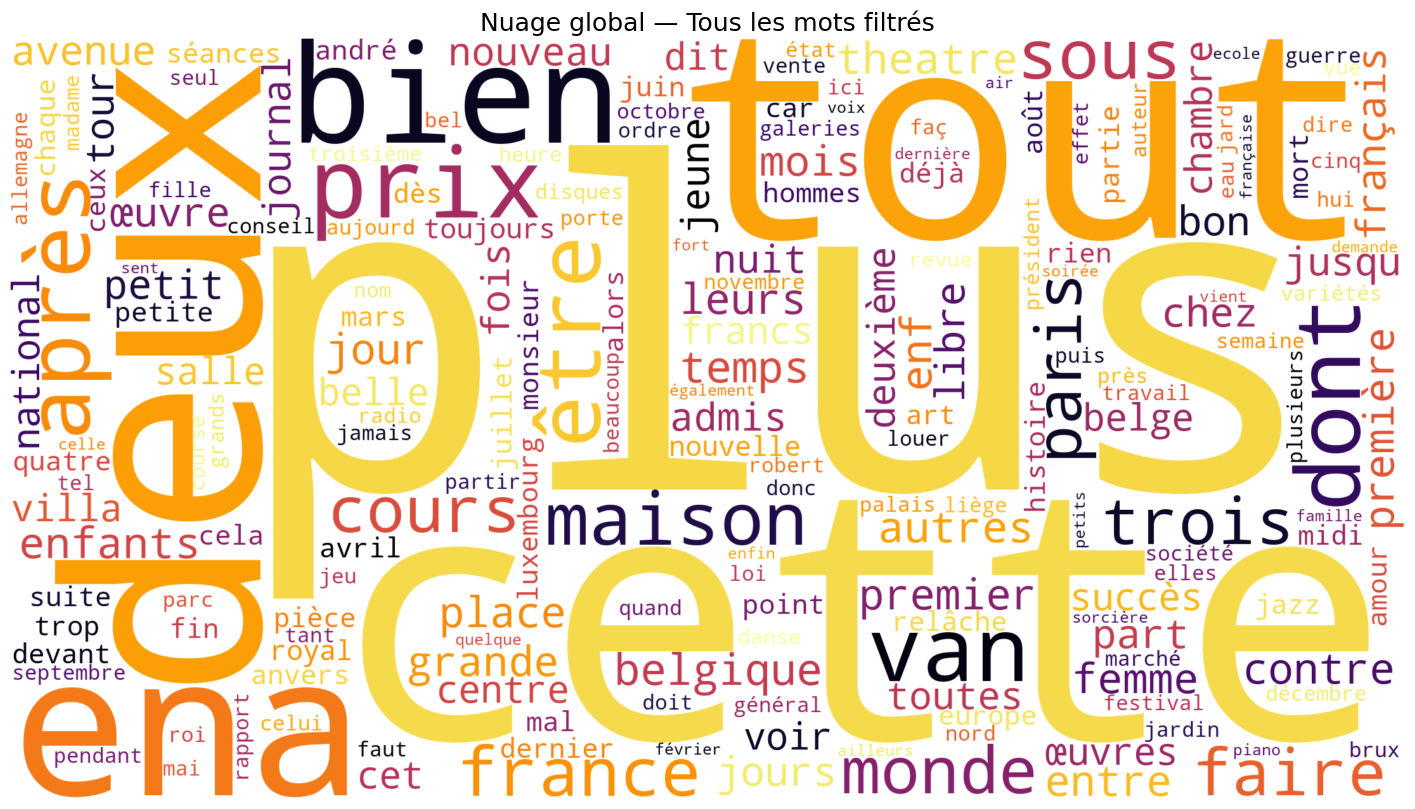

In [25]:
freq_global = Counter(corpus)

afficher_nuage(
    freq_global,
    titre="Nuage global — Tous les mots filtrés",
    save_path=f"{output_dir}nuage_global.png"
)


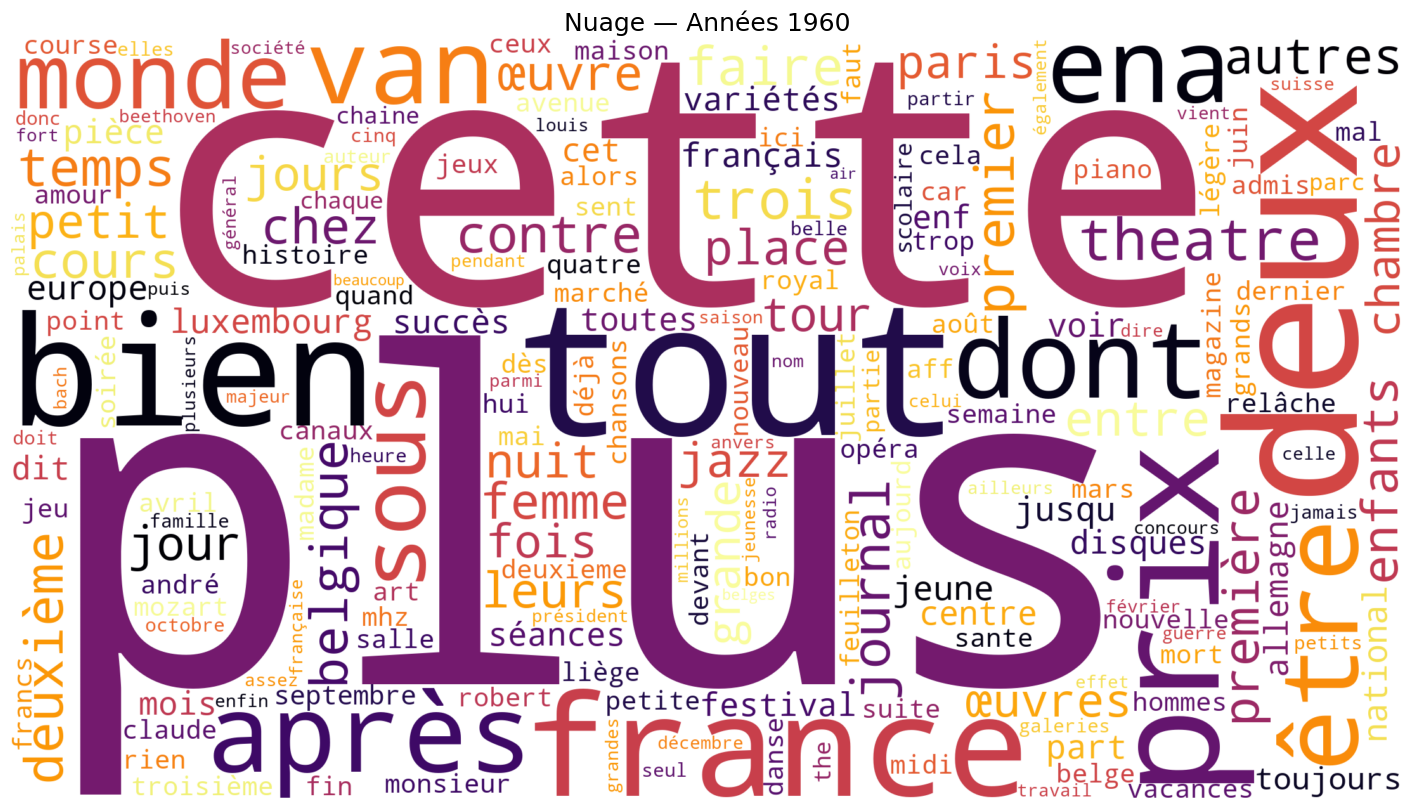

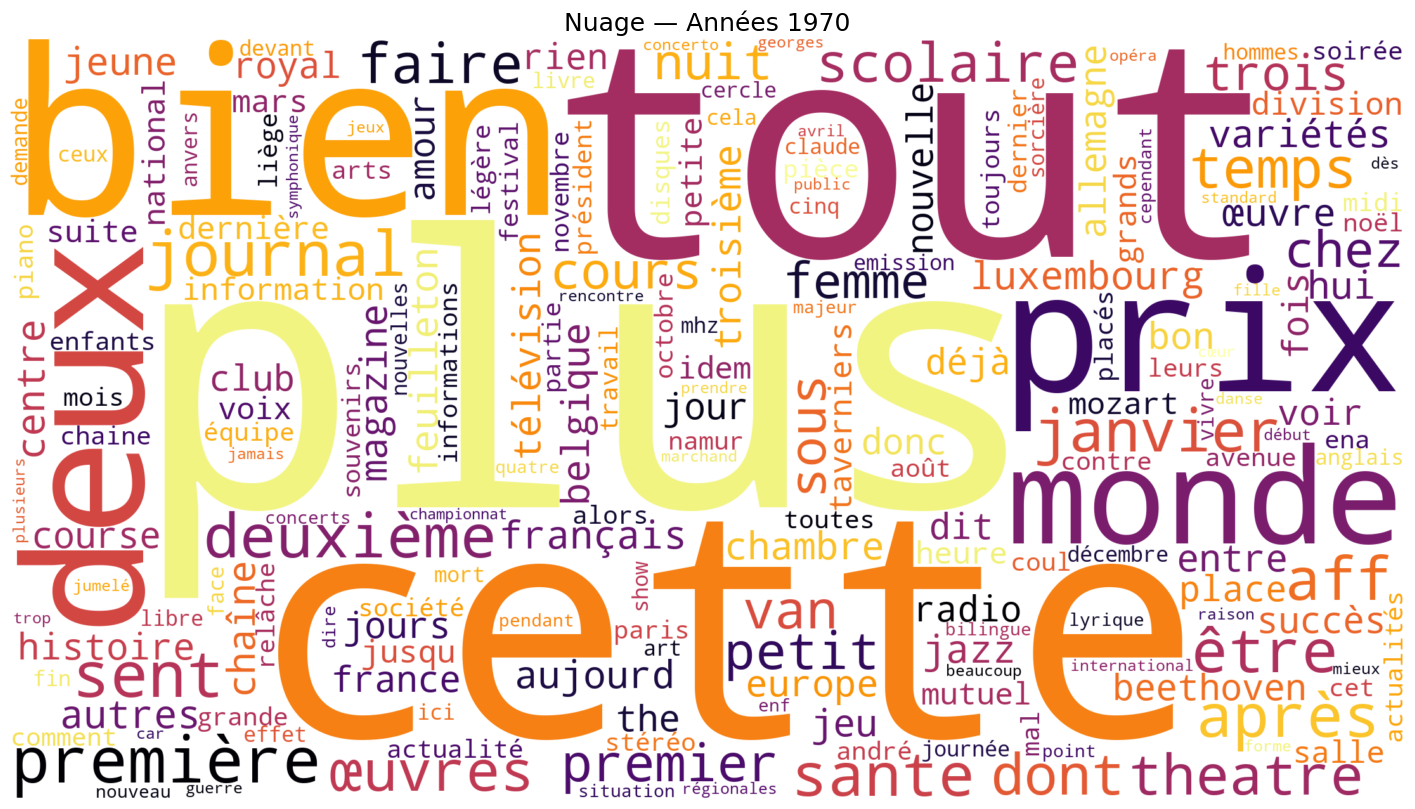

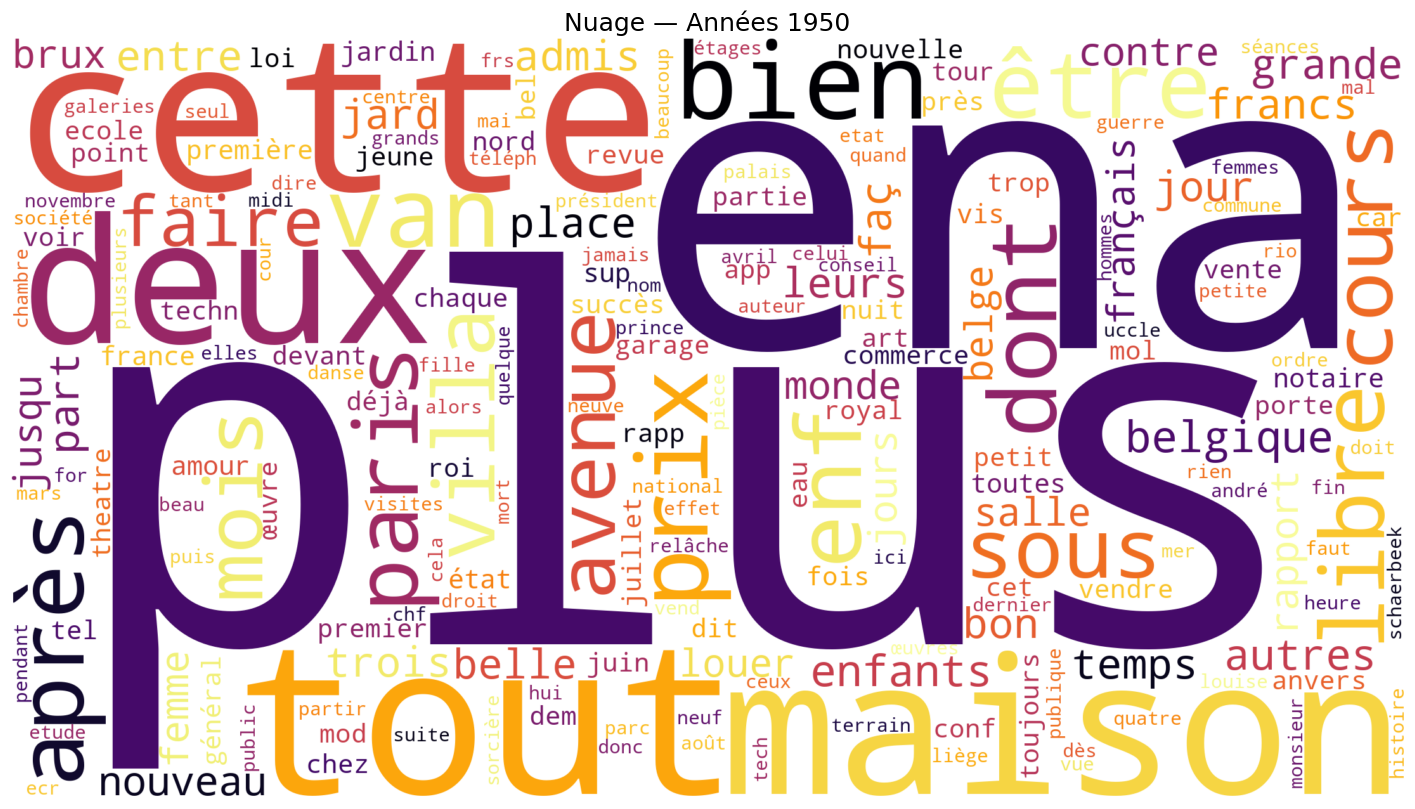

In [26]:
for dec, textes in corpus_decennies.items():
    words = " ".join(textes).split()
    freq = Counter(words)

    afficher_nuage(
        freq,
        titre=f"Nuage — Années {dec}",
        save_path=f"{output_dir}nuage_{dec}.png"
    )


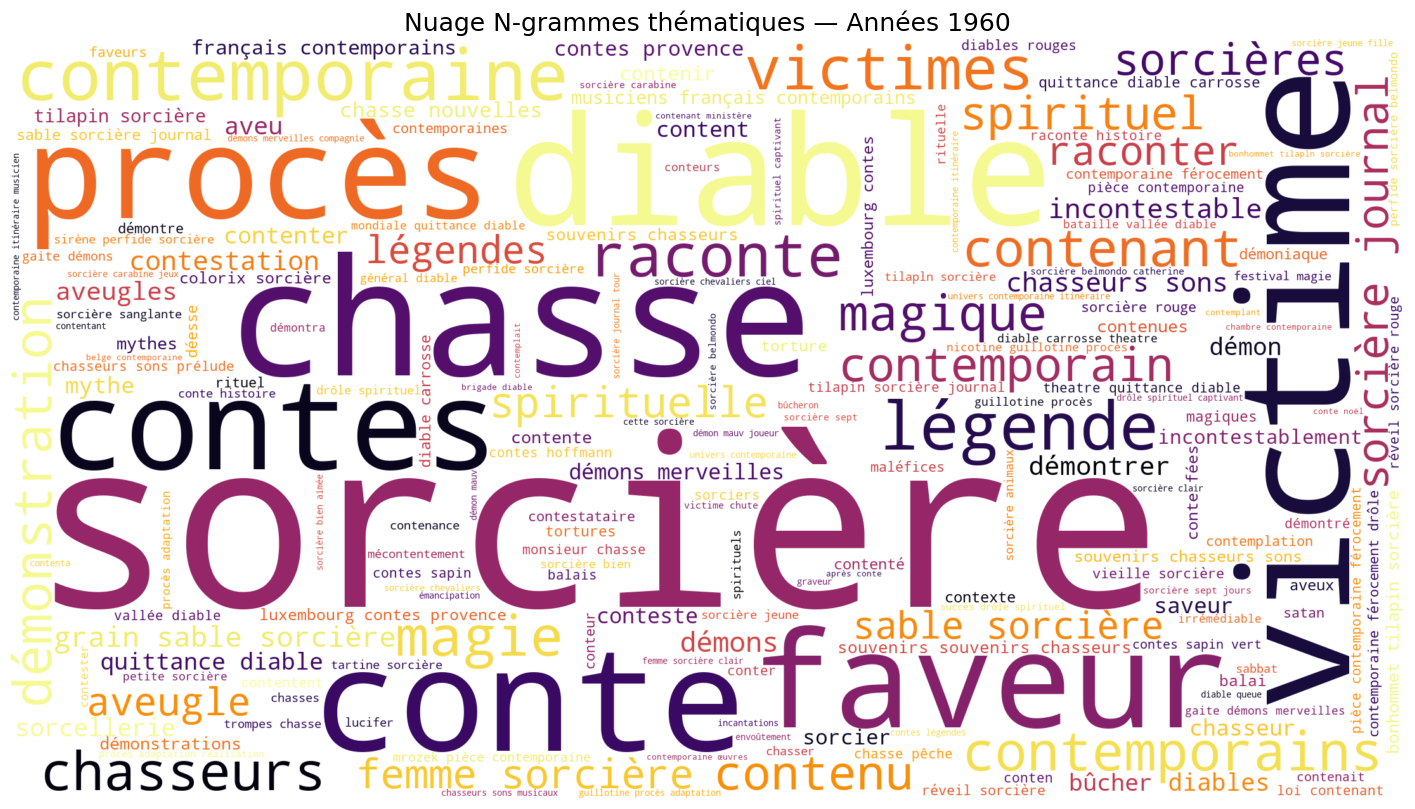

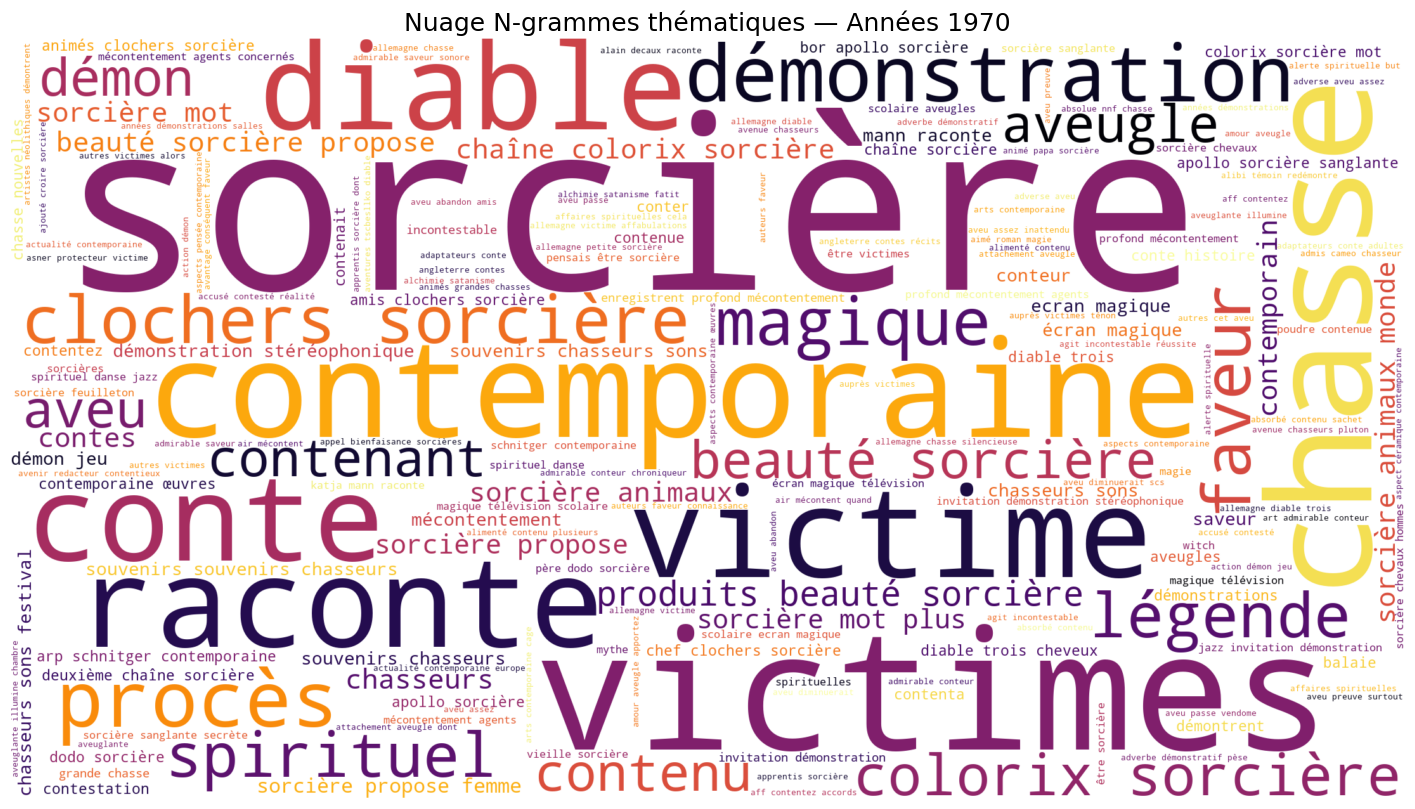

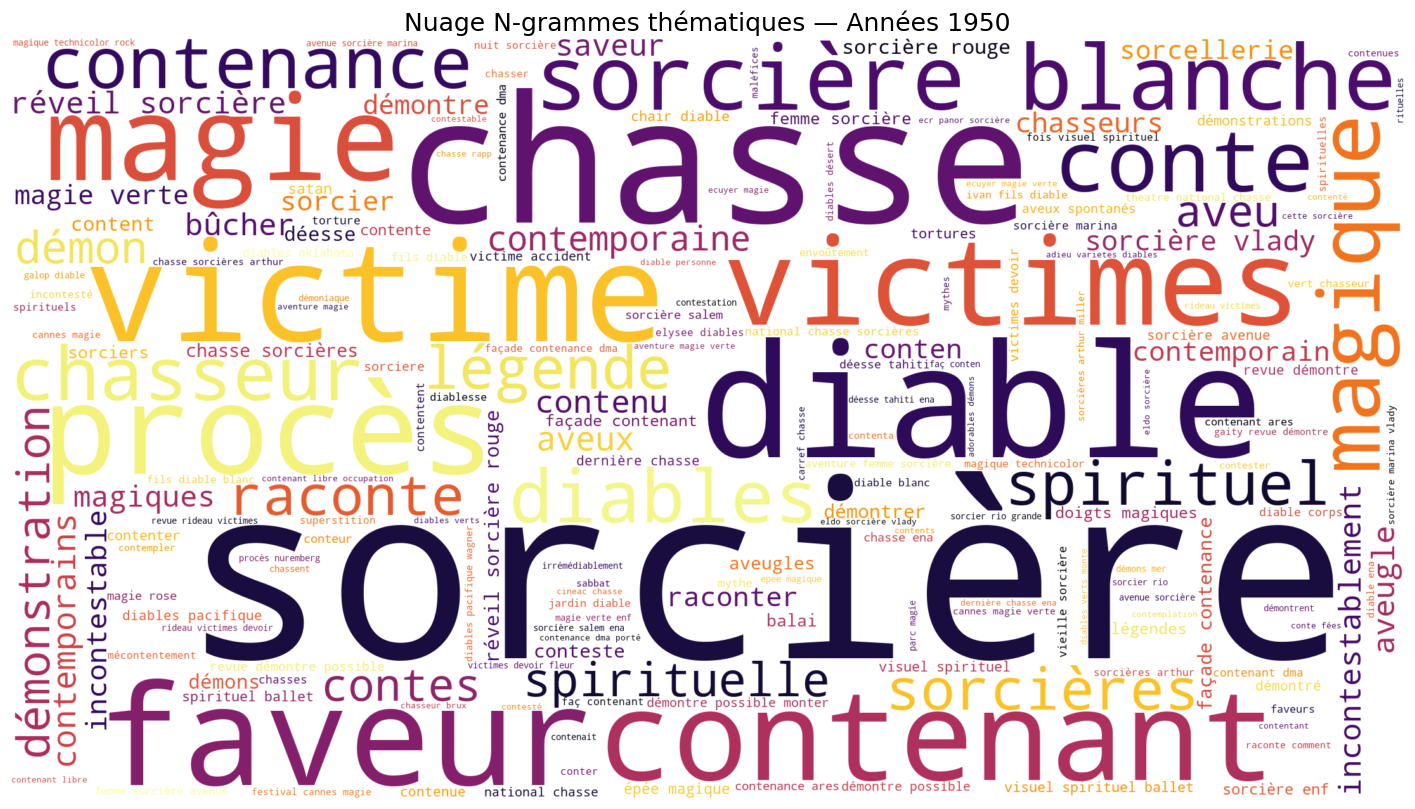

In [28]:
ngrams_decennies = {}

for dec, textes in corpus_decennies.items():
    combined = " ".join(textes)

    vectorizer = CountVectorizer(
        ngram_range=(1, 3),
        stop_words=list(stopwords_custom),
        min_df=1  
    )
    X = vectorizer.fit_transform([combined])

    feature_names = vectorizer.get_feature_names_out()
    counts = X.toarray()[0]

    # filtrage thématique
    ngram_counts = {
        feature_names[i]: counts[i]
        for i in range(len(feature_names))
        if any(m in feature_names[i] for m in mots_cibles)
    }

    ngrams_decennies[dec] = ngram_counts

    afficher_nuage(
        dict(sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:200]),
        titre=f"Nuage N-grammes thématiques — Années {dec}",
        save_path=f"{output_dir}ngrams_{dec}.png"
    )


In [29]:
with open(f"{output_dir}ngrams_thematiques.csv", "w", encoding="utf-8") as f:
    f.write("decennie;ngram;count\n")
    for dec, dico in ngrams_decennies.items():
        for ngram, count in dico.items():
            f.write(f"{dec};{ngram};{count}\n")


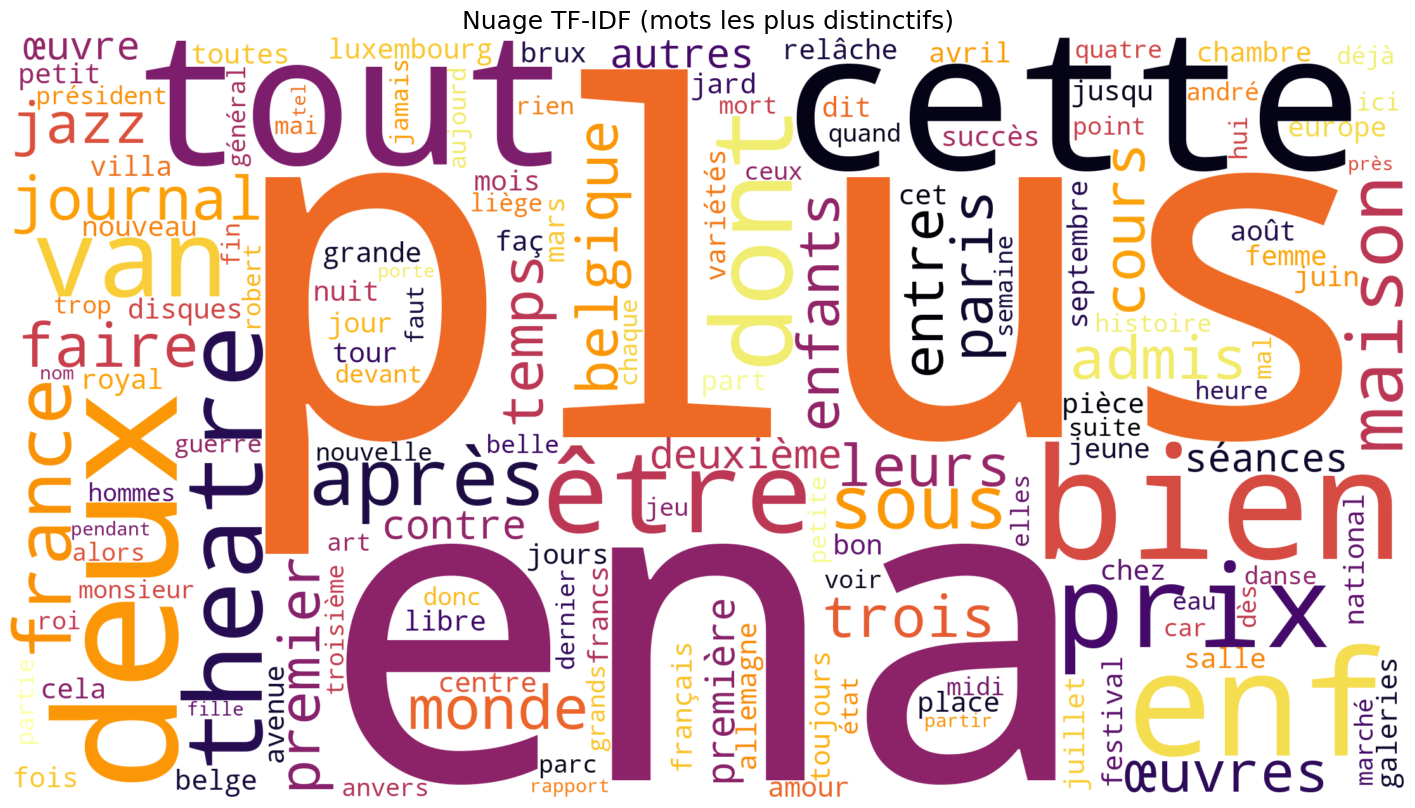

In [31]:
documents = [" ".join(filter_words(nettoyer_texte(open(os.path.join(data_path,f),'r',encoding='utf-8',errors='ignore').read()).split())) for f in files]

vectorizer = TfidfVectorizer(max_features=150)
X = vectorizer.fit_transform(documents)

# conversion correcte des valeurs
scores = X.toarray().mean(axis=0).astype(float)

tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), scores))

# tri
tfidf_sorted = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:150])

# affichage
afficher_nuage(
    tfidf_sorted,
    titre="Nuage TF-IDF (mots les plus distinctifs)",
    save_path=f"{output_dir}nuage_tfidf.png"
)

